## Batting Pitching Fielding

After my last notebook, Moneyball, I came to wonder in what areas in baseball are statistically important to winning. Thus, I decided to look at the games in three main categories: batting, pitching, and fielding.

    Question : From batting, pitching and fielding, what's most important in winning baseball?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
from scipy.stats import norm
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
cp = sns.color_palette('coolwarm',10)
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
df_team = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/Batting_Pitching_Fielding/data/Teams.csv')
df_pitch = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/Batting_Pitching_Fielding/data/Pitching.csv')
df_field = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/Batting_Pitching_Fielding/data/Fielding.csv')
df_ffield = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/Batting_Pitching_Fielding/data/fangraph_field.csv')

df_w = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/Batting_Pitching_Fielding/data/FanGraphs Leaderboard.csv')

## Feature Selection

#### **Pitching**

There are various stats that you can use to evaluate pitcher's performance, such as ERA, WHIP, FIP... In this analysis, we will be using FIP stats because it focuses soley on the events a pitcher has the most control over. FIP are intended as a measure of a pitcher's performance unaffected by the defense behind him.

-Pure Pitching skills!!

#### **Batting**

With batting, we have stats like OPS, OPS+, OBP... We will be using wOBA stat, which is the stat that is favored by many sabermetricians because of its accuracy and simplicity. wOBA is a version of on-base percentage that accounts for 'how' a player reached base instead of simply consedering whether a player reached base. The value for each base is determined by how much that event is worth in relation to projected run scored. Since hitter's main objective is to score runs, I thought that this would be a good stat to start with.

#### **Fielding**

Fielding is quite recent in baseball statistics. There are great indicators like UZR and DRS, but the data only exist from 2003. Thus, we need to find other indicator that can represent older baseballs. In this notebook, we will use FP(Fielding Percentage) to evaluate teams' fielding performance. 

FP is a measure that reflect the percentage of times a defensive player properly handles a batted or thrown ball. 

-------


For more information click [here](https://www.crawfishboxes.com/2015/4/30/8519577/sabermetrics-10-best-stats-more)

## Data Cleaning

### Add Feature

In [3]:
pitch_hbp = df_pitch.groupby(['yearID', 'teamID'])['HBP'].sum().to_frame().reset_index().copy()
pitch_hbp.rename(columns={'HBP':'PHBP'}, inplace=True)

df = pd.merge(df_team, pitch_hbp, how='left',on=['yearID','teamID'])
df = df.merge(df_w, how='left', left_on='yearID', right_on='Season')

# 1B = H - 2B - 3B - HR
df['1B'] = df.H - df['2B'] - df['3B'] - df.HR

# FIP = 13*HR + 3*(BB+HBP) - 2*SO)/(IPouts) + cFIP
df['FIP'] = ((df.HRA*13 + (df.BBA+df.PHBP)*3 - df.SOA*2)) / df.IPouts + df.cFIP

# wOBA = wBB*(BB-IBB) + wHBP*(HBP) + w1B*(1B) + w2B*(2B) + w3B*(3B) + wHR*(HR) / (AB+BB-IBB+SF+HBP)
df['wOBA_team'] = ((df.wBB*df.BB) + (df.wHBP*df.HBP) + (df.w1B*df['1B']) + (df.w2B*df['2B']) + (df.w3B*df['3B']) + (df.wHR*df.HR)) / (df.AB+df.BB+df.SF+df.HBP)

In [4]:
# Win percentage
df['Wp'] = df['W'] / df['G']

# time eras
# The free agency era 1977-1993
# The steroid era 1994-2005
# Post-Steroid era 2006-present
df['eras'] = 0
df.loc[(df["yearID"] >= 1977) & (df["yearID"] <= 1993),'eras'] = 'FreeAgency'
df.loc[(df["yearID"] >= 1994) & (df["yearID"] <= 2005),'eras'] = 'Steroid'
df.loc[(df["yearID"] >= 2006),'eras'] = 'PostSteroid'
df = df[df['eras'] != 0]

In [5]:
# extract feature that we will use
columns = ['yearID','teamID','wOBA_team','FIP','FP','W','Wp','eras']
df = df[columns]
df.shape

(1276, 8)

### Irregular Seasons

There are some irregular seasons that has shorten the season. We will see what those seasons are and get rid of those obsevations.

**1981 Major League Baseball Strike**
 - The strike began in on June 12 and forced the cancellation of 713 games.


**1994-95 Major League Baseball Strike**
 - The strike began on August 12 and resulted in the remainder of that season being cancelled.

**2020 COVID-19 Pandemic**
 - The season began on July 23 and ended on September 27 with only 60 games because of the COVID-19 pandemic.

 
--------------

For more information click [here](https://mlb.nbcsports.com/2020/03/13/looking-back-at-baseballs-previously-shortened-seasons/)


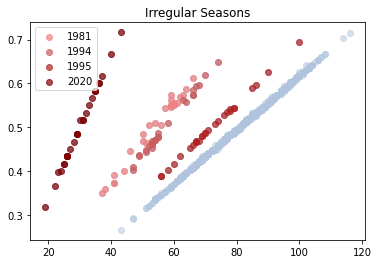

In [6]:
plt.title('Irregular Seasons')
plt.scatter(df.W, df['Wp'], color='lightsteelblue', alpha=0.5)
plt.scatter(df[df.yearID==1981]['W'], 
            df[df.yearID==1981]['Wp'], 
            color='lightcoral', 
            alpha=0.7,
            label=1981)
plt.scatter(df[df.yearID==1994]['W'], 
            df[df.yearID==1994]['Wp'], 
            color='indianred', 
            alpha=0.7,
            label=1994)
plt.scatter(df[df.yearID==1995]['W'], 
            df[df.yearID==1995]['Wp'], 
            color='firebrick', 
            alpha=0.7,
            label=1995)
plt.scatter(df[df.yearID==2020]['W'], 
            df[df.yearID==2020]['Wp'], 
            color='maroon', 
            alpha=0.7,
            label=2020)
plt.legend()
plt.show()

In [7]:
# drop values from irregular seasons
years = [1981, 1994, 1995, 2020]
df = df[df.yearID.isin(years) == False]

### Feature scaling

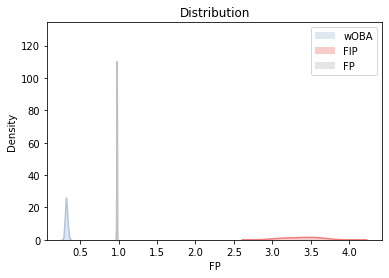

In [8]:
# feature scaling
sns.distplot(df.wOBA_team, label='wOBA', color='lightsteelblue')
sns.distplot(df.FIP, label='FIP', color='lightcoral')
sns.distplot(df.FP, label='FP', color='silver')
plt.title('Distribution')
plt.legend()
plt.show()

In [9]:
# scale to same variance so that we can compare them directly
sc = StandardScaler()
val = ['wOBA_team','FIP','FP']
df_scaled = df.copy()
sc.fit(df_scaled[val])
df_scaled[val] = sc.transform(df_scaled[val])

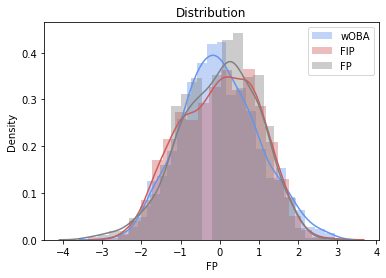

In [10]:
sns.distplot(df_scaled.wOBA_team, label='wOBA', color='cornflowerblue')
sns.distplot(df_scaled.FIP, label='FIP', color='indianred')
sns.distplot(df_scaled.FP, label='FP', color='grey')
plt.title('Distribution')
plt.legend()
plt.show()

## EDA

### Historical Era Comparison

MLB has endured many changes in rules, equipment, and strategies over time. Because of such shifts, Major League Baseball has been segmented into distinct eras. We will see if there are significant difference between each eras.

**The Free Agency Era (1977-1993)**

The foundations for free agency were established in 1966 with the MLB Players Association hiring Marvin Miller to be its executive director. Free agency marked a complete upheaval of a structure that had remained relatively unchanged for almost a century. In the first year twenty-four players became free agents, headlined by Reggie Jackson who signed a five-year $3 million deal with the Yankees. Players saw immediate results in the form of their salaries, and by 1979 the average salary was six times what it had been in 1966. There was a clear change in how the game was structured, and similar to the last half of the expansion era, the rules on the field again favored the hitters as runs per game rose and offense was perceived to have dominated pitching.

**The Steroid Era (1994-2005)**

The irony of the Steroid Era is that it begins after steroids made it on MLB’s banned substance list (1991), but continues past the time that MLB actually began testing major league players (2003). As baseball came back from the player’s strike in 1994, attendance declined rapidly. A strong argument is made that: “Steroids may have saved baseball after the 1994-1995 strike, [as the strike] angered fans and resulted in attendance dropping by almost 10 million in both the National and American leagues” (14). MLB needed a way to bring fans back to the parks, and it was not until the famed Home Run Race between Mark McGwire and Sammy Sosa in 1998 that attendance numbers recovered. For this reason, the argument has been made that MLB allowed steroid use to go unchecked, and therefore allowed an explosion of offensive numbers.

**Post-Steroid Era (2006-present)**

Beginning with the 2006 season, the penalties for testing positive for steroids (or any banned substance) became harsher than ever before. The 2006 season saw the implementation of a system where a player received a 50-game ban for a first offense, a 100-game ban for a second offense, and a lifetime ban for a third offense. The policy was again updated in 2014, and now includes an 80-game ban for a first offense, a 162-game ban for a second offense, and a lifetime ban for a third offense. Since 2012, a total of 30 players have been suspended for PED usage, including one lifetime ban. It is not a Post-Steroid Era in the sense that steroids have been removed from the game, but the idea is that the harsher penalties help deter players from using because the consequences are greater than ever.

----------------------

For more information click [here](https://thesportjournal.org/article/examining-perceptions-of-baseballs-eras/)


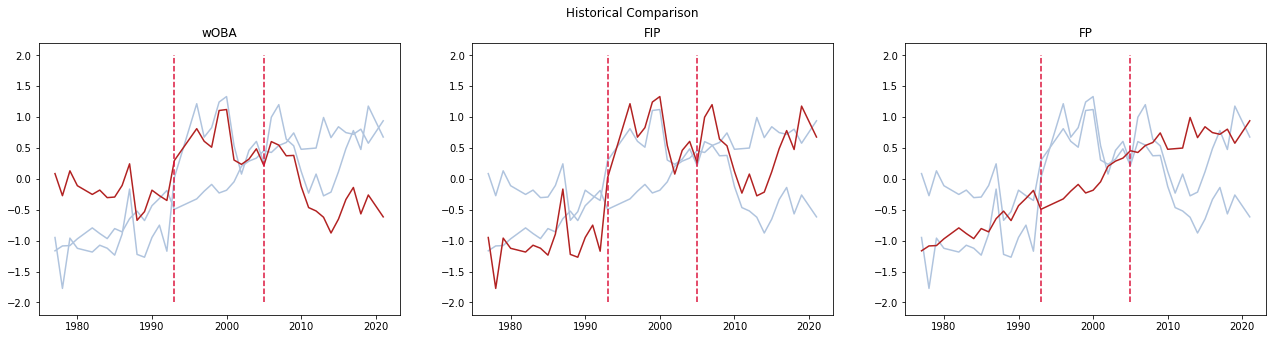

In [29]:
f,ax = plt.subplots(1,3,figsize=(22,5))
plt.suptitle('Historical Comparison')
# wOBA
ax[0].set_title('wOBA')
ax[0].plot(df_scaled[['yearID','FIP','FP']].groupby('yearID').mean(), color='lightsteelblue')
ax[0].plot(df_scaled[['yearID','wOBA_team']].groupby('yearID').mean(), color='firebrick')
# FIP
ax[1].set_title('FIP')
ax[1].plot(df_scaled[['yearID','wOBA_team','FP']].groupby('yearID').mean(), color='lightsteelblue')
ax[1].plot(df_scaled[['yearID','FIP']].groupby('yearID').mean(), color='firebrick')
# FP
ax[2].set_title('FP')
ax[2].plot(df_scaled[['yearID','wOBA_team','FIP']].groupby('yearID').mean(), color='lightsteelblue')
ax[2].plot(df_scaled[['yearID','FP']].groupby('yearID').mean(), color='firebrick')

for i in range(0,3):
    ax[i].vlines(1993, [-2],[2], linestyles='dashed', colors='crimson')
    ax[i].vlines(2005, [-2],[2], linestyles='dashed', colors='crimson')

It seems that the mean of each stats are changed from era to era. Now lets check if it is statistically true.

#### one-way ANOVA

***one-way ANOVA assumptions:***
- Normality
- Homoscedasticity
- Independence

We can see that 'FIP' and 'FP' is little skewed to the right.

In [12]:
# Yeo-Johnson Transformation is a way to transform continuous varialble 
# so that the resulting variable looks more normally distributed
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
values = ['wOBA_team','FIP','FP']
for i in values:
    val = df_scaled[values].values
    pt.fit(val)
    val_trans = pt.transform(val)
    df_scaled[values] = val_trans


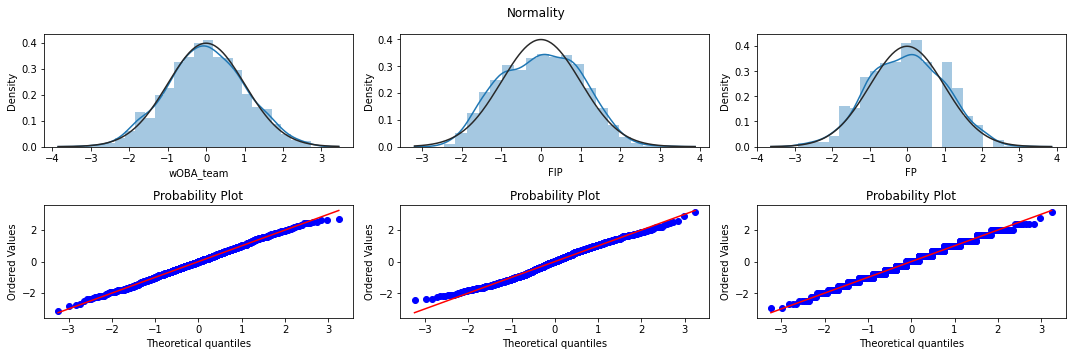

In [13]:
f,ax = plt.subplots(2,3,figsize=(15,5))
plt.suptitle('Normality')
sns.distplot(df_scaled.wOBA_team, label='wOBA', fit=norm, ax=ax[0,0])
sns.distplot(df_scaled.FIP, label='FIP', fit=norm, ax=ax[0,1])
sns.distplot(df_scaled.FP, label='FP', fit=norm, ax=ax[0,2])
stats.probplot(df_scaled.wOBA_team, plot=ax[1,0])
stats.probplot(df_scaled.FIP, plot=ax[1,1])
stats.probplot(df_scaled.FP, plot=ax[1,2])
plt.tight_layout()
plt.show()

In [14]:
# Homoscedasticity -> Standardscaler but lets check anyway
# Levene's test
from scipy.stats import levene
result = levene(df_scaled.wOBA_team, df_scaled.FIP, df_scaled.FP)
pd.DataFrame(result, index = ['statistics','p-value'], 
                columns=['Levene\'s test']).T

,statistics,p-value
Levene's test,0.760156,0.467671


We used **Levene's test** to check if the data have equal variance. 
The null and alternative hypotheses of Leven's test are:

$ H_0 = \sigma_1^2 = \sigma_2^2 = \sigma_3^2 $

$ H_1 = \sigma_i^2 \neq \sigma_j^2 $

Since the p-value is more than 0.05, we have strong evidence that the data are close to having equal variance.

Now that we got our assumptions statisfied, we will perform **one-way ANOVA test**. The null and alternative hypotheses of the one-way ANOVA test are:


$ H_0 = \mu_1 = \mu_2 = \mu_3 $

$ H_1 = \mu_i \neq \mu_j $
        

In [15]:
model = ols('wOBA_team ~ C(eras)', df_scaled).fit()
a = anova_lm(model)
model = ols('FIP ~ C(eras)', df_scaled).fit()
a = a.append(anova_lm(model))
model = ols('FP ~ C(eras)', df_scaled).fit()
a.append(anova_lm(model))


,df,sum_sq,mean_sq,F,PR(>F)
C(eras),2.0,129.989907,64.994954,72.977181,1.399357e-30
Residual,1161.0,1034.010093,0.890620,NaN,NaN
C(eras),2.0,645.060449,322.530225,721.582293,2.185651e-204
Residual,1161.0,518.939551,0.446976,NaN,NaN
C(eras),2.0,432.501539,216.250770,343.223065,7.765747e-118
Residual,1161.0,731.498461,0.630059,NaN,NaN


According to the test above, the p-value is approximately 0, thus we reject $H_0$ and have strong evidence that there's at least one pairwise group mean difference in each stats at a 5% significant level.

### vs Wins

In [16]:
df_free = df[df.eras == 'FreeAgency']
df_ster = df[df.eras == 'Steroid']
df_post = df[df.eras == 'PostSteroid']

In [17]:
# Winning and Losing Team Differece in Stats
# First Quarter of Wp -> Losing Team
Q1 = df_scaled['Wp'].describe()['25%']
# Fourth Quarter of Wp -> Winning Team
Q3 = df_scaled['Wp'].describe()['75%']

df_lose = df_scaled[df_scaled['Wp'] < Q1]
df_win = df_scaled[df_scaled['Wp'] > Q3]

Text(0.5, 1.0, 'Winning Team')

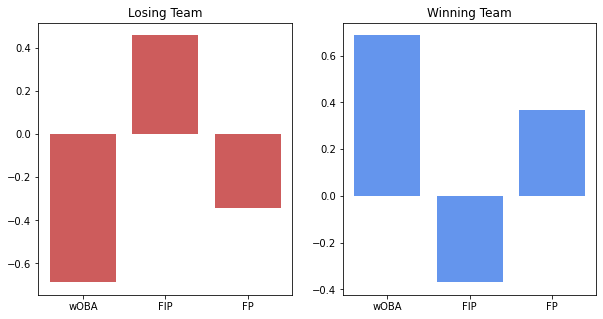

In [18]:
lose = df_lose[['wOBA_team', 'FIP', 'FP']].mean()
win = df_win[['wOBA_team', 'FIP', 'FP']].mean()

stat = ['wOBA','FIP','FP']
f,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(stat, lose, color='indianred')
ax[0].set_title('Losing Team')
ax[1].bar(stat, win, color='cornflowerblue')
ax[1].set_title('Winning Team')

## Feature Importance (Linear Regression)

#### wOBA

In [19]:
field = df_field.groupby(['teamID', 'yearID']).sum().reset_index().copy()
# field percentage = (PO + A) / (PO + A + E)
field['FFP'] = (field.PO + field.A) / (field.PO + field.A + field.E)
# df_scaled['FFP'] = field['FP']
df_scaled = df_scaled.merge(field[['teamID','yearID','FFP']], how='left', on=['teamID','yearID'])

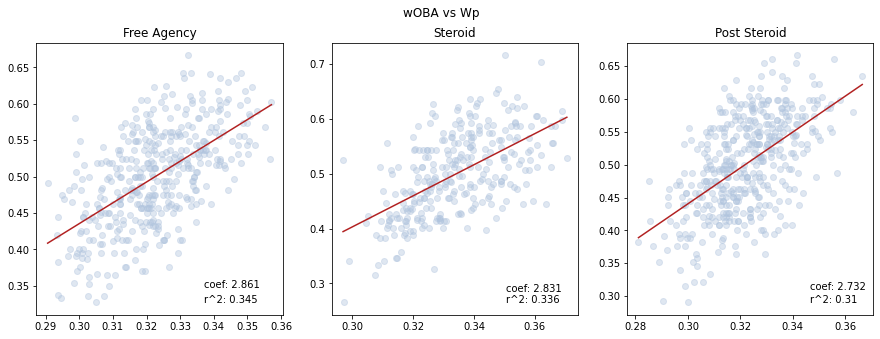

In [20]:
f,ax = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('wOBA vs Wp')
ax[0].set_title('Free Agency')
ax[1].set_title('Steroid')
ax[2].set_title('Post Steroid')

data = [df_free, df_ster, df_post]
cor = []
for n, era in enumerate(data):
    X = era['wOBA_team'].values\
                        .reshape(-1,1)
    y = era['Wp'].values\
                 .reshape(-1,1)
    lr = LinearRegression()
    lr.fit(X,y)
    
    ax[n].scatter(X, y, color='lightsteelblue', alpha=0.4)
    ax[n].plot([min(X),max(X)], 
               [min(X)*lr.coef_[0]+lr.intercept_,max(X)*lr.coef_[0]+lr.intercept_],
                color='firebrick')

    ax[n].text(max(X)-0.02,min(y)+0.02,
               f'coef: {round(lr.coef_[0][0],3)}')
    ax[n].text(max(X)-0.02,min(y),
               f'r^2: {round(lr.score(X,y),3)}')

#### FIP

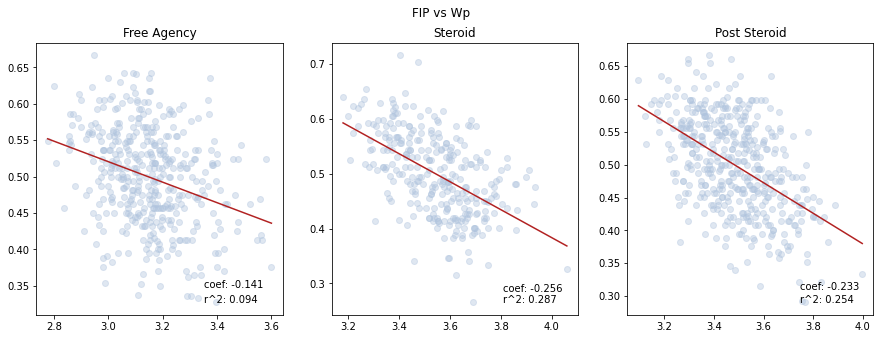

In [21]:
f,ax = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('FIP vs Wp')
ax[0].set_title('Free Agency')
ax[1].set_title('Steroid')
ax[2].set_title('Post Steroid')

data = [df_free, df_ster, df_post]
cor = []
for n, era in enumerate(data):
    X = era['FIP'].values\
                        .reshape(-1,1)
    y = era['Wp'].values\
                 .reshape(-1,1)
    lr = LinearRegression()
    lr.fit(X,y)
    
    ax[n].scatter(X, y, color='lightsteelblue', alpha=0.4)
    ax[n].plot([min(X),max(X)], 
               [min(X)*lr.coef_[0]+lr.intercept_,max(X)*lr.coef_[0]+lr.intercept_],
                color='firebrick')

    ax[n].text(max(X)-0.25,min(y)+0.02,
               f'coef: {round(lr.coef_[0][0],3)}')
    ax[n].text(max(X)-0.25,min(y),
               f'r^2: {round(lr.score(X,y),3)}')

#### FP

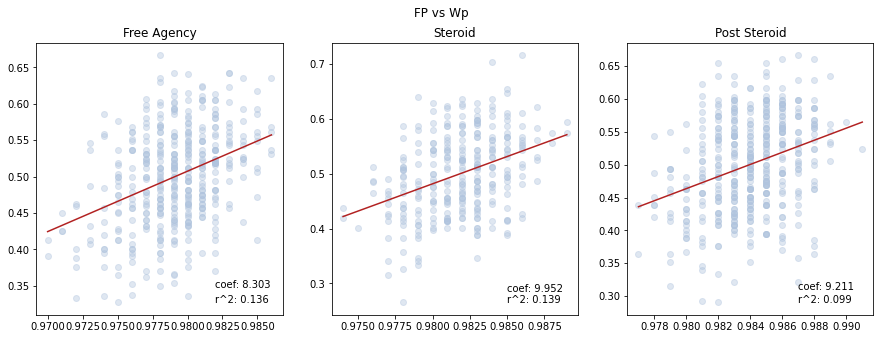

In [22]:
f,ax = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('FP vs Wp')
ax[0].set_title('Free Agency')
ax[1].set_title('Steroid')
ax[2].set_title('Post Steroid')

data = [df_free, df_ster, df_post]
cor = []
for n, era in enumerate(data):
    X = era['FP'].values\
                        .reshape(-1,1)
    y = era['Wp'].values\
                 .reshape(-1,1)
    lr = LinearRegression()
    lr.fit(X,y)
    
    ax[n].scatter(X, y, color='lightsteelblue', alpha=0.4)
    ax[n].plot([min(X),max(X)], 
               [min(X)*lr.coef_[0]+lr.intercept_,max(X)*lr.coef_[0]+lr.intercept_],
                color='firebrick')

    ax[n].text(max(X)-0.004,min(y)+0.02,
               f'coef: {round(lr.coef_[0][0],3)}')
    ax[n].text(max(X)-0.004,min(y),
               f'r^2: {round(lr.score(X,y),3)}')

In [23]:
ols(formula = 'Wp ~ wOBA_team + FIP + FP', data=df_scaled).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Wp   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     604.0
Date:                Tue, 29 Mar 2022   Prob (F-statistic):          2.26e-236
Time:                        23:21:43   Log-Likelihood:                 1976.0
No. Observations:                1164   AIC:                            -3944.
Df Residuals:                    1160   BIC:                            -3924.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4998      0.001    384.185      0.000       0.497       0.502
wOBA_team      0.0442      0.001     33.082      0.000       0.042       0.047
FIP           -0.0396      0.001    -28.305      0.000      -0.042      -0.037
FP             0.0268      0.001     19.549      0.000       0.024       0.030
==============================================================================
Omnibus:                        0.994   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                1.049
Skew:                           0.030   Prob(JB):                        0.592
Kurtosis:                       2.866   Cond. No.                         1.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Feature Importance (Random Forest)

In [24]:
def rf_importance(X,y):
	model = RandomForestRegressor(n_estimators = 100)
	model.fit(X, y)
	importances = model.feature_importances_

	indices = np.argsort(importances)[::-1]

	# print('Feature Ranking:')

	# for f in range(X.shape[1]):
	# 	print('%d. features %d (%f)'% (f+1, indices[f], importances[indices[f]]))

	print(model.score(X,y))
	
	return importances

In [25]:
rf_importance(df_scaled[['wOBA_team', 'FIP', 'FP']], df_scaled['Wp'])

0.9392669162510712


array([0.49444717, 0.37092943, 0.1346234 ])

In [26]:
result = []
for era in data:
    X = era[['wOBA_team', 'FIP', 'FP']]
    y = era['Wp']
    result.append(rf_importance(X,y))

0.9371074960410813
0.9533793319665056
0.939779766128938


In [27]:
pd.DataFrame(result, 
             columns=['wOBA', 'FIP', 'FP'], 
             index=['Free Agency', 'Steroid', 'Post Steroid'])

,wOBA,FIP,FP
Free Agency,0.535323,0.354936,0.109741
Steroid,0.515395,0.421180,0.063425
Post Steroid,0.477591,0.421200,0.101209
